### Multiple linear regression with kfold Cross-validation code for bacterial dataset

In [66]:
#Import python libraries/packages

# Pandas to handle dataframes
import pandas as pd    

# Import Scikit-Learn library for the regression model
import sklearn         
from sklearn import preprocessing #sklearn for normalization function
from sklearn import linear_model, datasets
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
# SequentialFeatureSelector
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# Another statistic model library
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d

# Import numpy 
import numpy as np

# Import plotting libraries
import matplotlib 
from matplotlib import pyplot as plt
# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 18})

In [67]:
# Open and load dataset
bacterial_csv = pd.read_csv('compiled_features_complete.csv')
df = pd.DataFrame(data=bacterial_csv)
df

,Unnamed: 0,GENENAME,ORG,ENTREZID,REFSEQ,LOG2FC,True_EID,SEQUENCE,AA_NP,AA_POS,AA_POL,AA_NEG,MW,AROM,ISO_E
0,0,ABC_transporter,PA,879411,NP_248876,-0.038469,15595384,mkaltssllglfaapvlagllgayvplasaappkeiriavpdvsag...,59.773371,11.614731,17.847025,10.764873,37193.0756,0.070822,6.871061
1,1,ABC_transporter,PA,883108,NP_248894,-0.207718,15595400,mhqriasiglgltlalggsaqaagqlnvvswsgyfspqllekfeke...,54.941860,11.337209,22.674419,11.046512,37859.8560,0.093023,6.033937
2,2,ABC_transporter,PA,878380,NP_249014,-0.187309,15595520,mtyrtpltllfaaglalggqaraegtlhfanwsdyyppellkkfek...,52.449568,14.121037,20.461095,12.968300,38901.0268,0.112392,6.350359
3,3,ABC_transporter,PA,880771,NP_249293,0.085173,15595799,mlpamrtgllcallgvtapawaeyvtvisfggankeaqetafykpf...,59.593023,11.918605,17.732558,10.755814,37832.8132,0.116279,6.919602
4,4,ABC_transporter,PA,879023,NP_249295,0.038834,15595801,mskslkaaslkfatlaaglacaaqamavdltvvsfgganksaqika...,54.310345,11.494253,22.413793,11.781609,38166.9526,0.112069,5.869103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,431,RNA_polymerase,BS,939937,NP_388354,-0.055848,728883360,mtqpskttkltkdevdrlisdyqtkqdeqaqetlvrvytnlvdmla...,42.748092,16.030534,24.809160,16.412214,29900.8971,0.049618,5.545803
432,432,RNA_polymerase,BS,936362,NP_391300,-0.140629,728886343,mdmklqqvqvlkpqltqelrqaitllgyhsaelaeyidelslenpl...,43.807339,15.596330,27.752294,12.844037,49700.0669,0.064220,7.716086
433,433,RNA_polymerase,BS,938729,NP_390226,-0.528350,728885268,mdvevkkngknaqlkdhevkelikqsqngdqqardllieknmrlvw...,43.137255,16.862745,21.568627,18.431373,29372.0675,0.058824,5.252059
434,434,RNA_polymerase,BS,939953,NP_389416,0.303125,728884442,msrnkveicgvdtsklpvlkneemrklfrqlqdegddsareklvng...,45.384615,16.153846,21.923077,16.538462,30073.0463,0.061538,5.632312


In [68]:
#assign input (X) /output (y) features
X= df[['AA_NP','AA_POS','AA_NEG', 'AA_POL', 'MW', 'AROM', 'ISO_E']]
y= df['LOG2FC']

#Change as you decrease/select input features!!
#Nfeat is number of input features
Nfeat = X.shape[1]

#### Scale input features (Rory will write a function, need to implement later)
for now just do a jupyter notebook lines

In [69]:
X_arr = X.values #returns a numpy array for X (needed to use the min_max_scaler)

X_col_names = list(X.columns.values.tolist()) #get column names to then put back into X_norm

#min-max normalization (rescaling) of input features
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_arr)
X_norm= pd.DataFrame(X_scaled)

#put back the original column names
X_norm.columns = X_col_names

X = X_norm

In [70]:
X

,AA_NP,AA_POS,AA_NEG,AA_POL,MW,AROM,ISO_E
0,0.560010,0.473362,0.223260,0.250886,0.208999,0.329985,0.380891
1,0.452176,0.457427,0.231083,0.387387,0.213203,0.452431,0.267864
2,0.396551,0.617272,0.284465,0.324803,0.219767,0.559252,0.310587
3,0.555985,0.490810,0.223009,0.247650,0.213032,0.580691,0.387445
4,0.438081,0.466444,0.251502,0.380018,0.215139,0.557471,0.245608
...,...,...,...,...,...,...,...
431,0.180024,0.726915,0.380126,0.447750,0.163027,0.213046,0.201957
432,0.203666,0.701983,0.281013,0.530971,0.287848,0.293578,0.494985
433,0.188710,0.774700,0.436212,0.356120,0.159693,0.263815,0.162296
434,0.238869,0.733995,0.383633,0.366142,0.164112,0.278788,0.213637


#### Function to do multiple linear regression with k-fold Cross-validation
multilinregr_kf(n_split):

In [108]:
def multilinregr_kf(n_split, X, y):
#the function will split test/train data with k-fold cross validation
#model used is multiple linear regression
#will return test/train datasets, prediction, and a list of MSE based on k-fold CV
    kf = KFold(n_splits=split_num, shuffle=True)
    MSE_kf = []
    for train_index, test_index in kf.split(X):
        #split train/test dataset with k-fold cross validation
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        #Define method and fit to the train set
        model = linear_model.LinearRegression().fit(X_train, y_train)
        y_predict = model.predict(X_test)
        MSE_kf.append(mean_squared_error(y_test, y_predict))
        
        kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
              
        mlr_params = [model.coef_,model.intercept_,kf_cv_scores]
        
    return X_train, X_test, y_train, y_test, y_predict, MSE_kf, mlr_params

In [136]:
#split num is a changeable parameter
split_num = 40


X_train, X_test, y_train, y_test, y_predict, MSE_kf, mlr_params= multilinregr_kf(split_num, X, y)
# mlr_params list consists of [model.coef_,model.intercept_,kf_cv_scores]

In [137]:
MLR_coeffs = mlr_params[0]
MLR_intercept = mlr_params[1]
kf_cv_scores = mlr_params[2]

#print the regression coefficients (beta values) and intercept (beta zero)
print(f"The multiple linear regression coefficients are {MLR_coeffs}")
print(f"The multiple linear regression intercept is {MLR_intercept}")

The multiple linear regression coefficients are [-9.11539393e+13 -3.54315129e+13 -7.32425041e+13 -7.19490237e+13
 -6.28117673e-02 -1.45721333e-01 -2.70305475e-04]
The multiple linear regression intercept is 102222190805710.61


In [138]:
#Evaluate model and report performance


#Print kfold cross validation scores
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

#calculate mean MSE from all iterations
mean_kf_MSE = (1/split_num) *np.sum(MSE_kf)
print("Mean MSE from test data using k-fold CV", mean_kf_MSE)

#calculate R^2 value (best value = 1, negative if we have huge error)
print('Coefficient of determination (R^2 value): %.2f' % r2_score(y_test, y_predict))

K-fold CV average score: -0.24
Mean MSE from test data using k-fold CV 0.08722862352763701
Coefficient of determination (R^2 value): -0.04


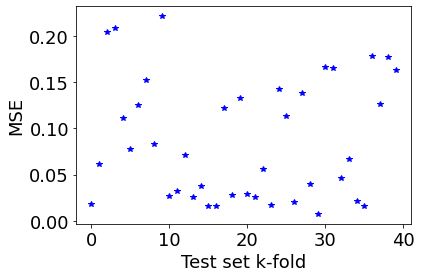

In [139]:
#plot MSE values at every k-fold iteration    
plt.figure()
plt.plot(MSE_kf,'*',color='blue')
plt.xlabel('Test set k-fold')
plt.ylabel('MSE')
plt.show()

#### Check y_test and y_predict per input features

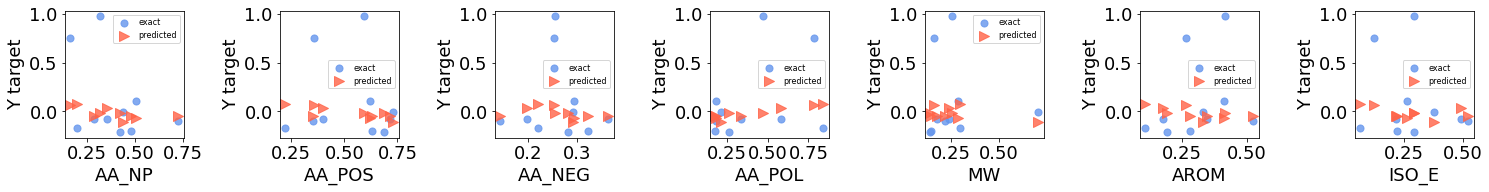

In [140]:
# Plot LogFC output feature per input feature
feature_names = np.array(list(X.columns))
fig, ax = plt.subplots(1,Nfeat,figsize=(Nfeat*3,3))
for i in range(Nfeat):
  
    ax[i].scatter(X_test.iloc[:,i], y_test, s=50, marker='o', color="cornflowerblue", alpha=0.8, label="exact")
    ax[i].scatter(X_test.iloc[:,i], y_predict, s=100, marker='>', color="tomato", alpha=0.8, label="predicted")
    ax[i].set_xlabel(feature_names[i])
    ax[i].set_ylabel('Y target')
    ax[i].legend(fontsize=8)

plt.tight_layout()

#### if not using MLR k-fold CV function:

In [10]:
#Apply cross-validation with a k-fold method
split_num = 5
kf = KFold(n_splits=split_num, shuffle=True)

In [22]:
#Check MSE at each iteration when doing cross-validation k-fold
MSE_kf = []
for train_index, test_index in kf.split(X):
    #split train/test dataset with k-fold cross validation
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Define method and fit to the train set
    model = linear_model.LinearRegression().fit(X_train, y_train)
    y_predict = model.predict(X_test)
    MSE_kf.append(mean_squared_error(y_test, y_predict))

In [ ]:
#plot MSE values at every k-fold iteration    
plt.figure()
plt.plot(MSE_kf,'*',color='blue')
plt.xlabel('Test set k-fold')
plt.ylabel('MSE')
plt.show()

In [2]:
#print the regression coefficients (beta values) and intercept (beta zero)
print("The multiple linear regression coefficients are" % model.coef_)
print("The multiple linear regression intercept is" % model.intercept_)

In [24]:
#Evaluate model and report performance

#Calculate kfold cross validation scores
kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kf )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

#calculate mean MSE from all iterations
mean_kf_MSE = (1/split_num) *np.sum(MSE_kf)
print("Mean MSE from test data using k-fold CV", mean_kf_MSE)

#calculate R^2 value (best value = 1, negative if we have huge error)
print('Coefficient of determination (R^2 value): %.2f' % r2_score(y_test, y_predict))

K-fold CV average score: -0.05
Mean MSE from test data using k-fold CV 0.08558595823361925
Coefficient of determination (R^2 value): -0.03


#### plot test output feature and predicted output feature

In [62]:
def plot_prediction(y_test, y_predict):
#the function will plot prediction and test output data
#to see how acurrate the prediction data are
    x_ax = range(len(y_test))
    plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
    plt.plot(x_ax, y_predict, lw=0.8, color="red", label="predicted")
    plt.legend(loc='upper right', prop={'size': 10})
    plt.show()

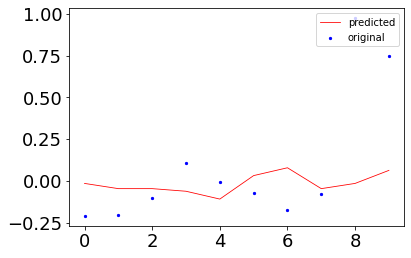

In [141]:
#visualize the original and predicted test data in a plot
plot_pred = plot_prediction(y_test, y_predict)

#### what if we vary the Split ratios, collect average MSE and R2 values in a list

In [89]:
def MLR_kf_splitvar(split_list, X, y):
#the function will split test/train data with k-fold cross validation
#model used is multiple linear regression
#will return test/train datasets, prediction, and a list of MSE based on k-fold CV
    kf = KFold(n_splits=split_num, shuffle=True)
    MSE_diffkf = []
    R2_diffkf = []
    score_diffkf = []
    for i in range(len(split_list)):
        MSE_kf = []
        for train_index, test_index in kf.split(X):
            #split train/test dataset with k-fold cross validation
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
            #Define method and fit to the train set
            model = linear_model.LinearRegression().fit(X_train, y_train)
            y_predict = model.predict(X_test)
            MSE_kf.append(mean_squared_error(y_test, y_predict))
        
            kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
            
        R2 = r2_score(y_test, y_predict)
        
        mean_kf_MSE = (1/split_list[i]) *np.sum(MSE_kf)
        
        MSE_diffkf.append(mean_kf_MSE)
        R2_diffkf.append(R2)
        score_diffkf.append(kf_cv_scores)
        
        return MSE_diffkf, R2_diffkf, score_diffkf

In [90]:
split_list = [5,10,15,20,25]
MSE_diffkf, R2_diffkf, score_diffkf = MLR_kf_splitvar(split_list, X, y)

In [91]:
MSE_diffkf

[0.0865558137366029]

In [92]:
R2_diffkf

[-0.013773779761899974]

In [93]:
score_diffkf

[array([-0.32505678, -0.08313089, -0.04331435, -0.0316221 , -0.02019018])]